..**Predicting the energy output of wind turbine based on weather condition**

Develop a time series model to Predict the power output of wind farm based on the weather condition in the site (1Hr prediction to 72Hrs. prediction) Build an application to recommend the Power Grid to suggest the best time to utilize the energy from wind farm

In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# **Approaches**

## 1.  Time seires -> Wind speed and direction -> MLP -> Power Forecast 
## 2.  Logistic on Speed + 





In [0]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

In [4]:
data=pd.read_csv('/content/drive/My Drive/Datasets /Wind Turbine Dataset.csv')
df = data.rename(columns={"LV ActivePower (kW)":"Active Power", "Wind Speed (m/s)":"Wind Speed", "Theoretical_Power_Curve (KWh)":"Theoritical Power", "Wind Direction (°)":"Direction"})
df

,Date/Time,Active Power,Wind Speed,Theoritical Power,Direction
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286
...,...,...,...,...,...
50525,31 12 2018 23:10,2963.980957,11.404030,3397.190793,80.502724
50526,31 12 2018 23:20,1684.353027,7.332648,1173.055771,84.062599
50527,31 12 2018 23:30,2201.106934,8.435358,1788.284755,84.742500
50528,31 12 2018 23:40,2515.694092,9.421366,2418.382503,84.297913


In [5]:
df['Loss']= df['Theoritical Power']-df['Active Power']
df.head()

,Date/Time,Active Power,Wind Speed,Theoritical Power,Direction,Loss
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904,36.281117
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113,66.148316
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789,84.523429
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087,96.481664
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286,111.052276


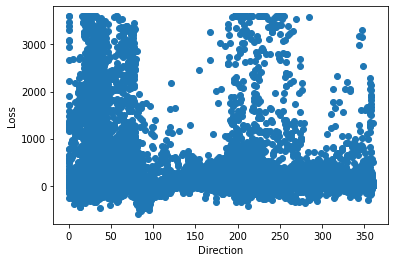

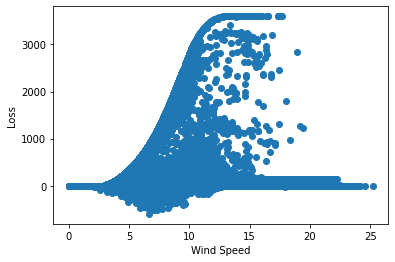

In [6]:
plt.scatter(df['Direction'],df['Loss'])
plt.xlabel('Direction')
plt.ylabel('Loss')
plt.show()

plt.scatter(df['Wind Speed'],df['Loss'])
plt.xlabel('Wind Speed')
plt.ylabel('Loss')
plt.show()


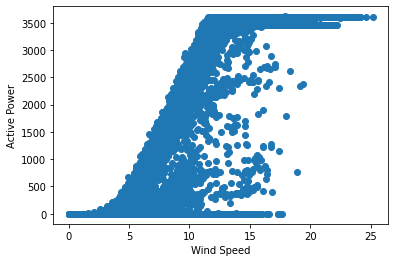

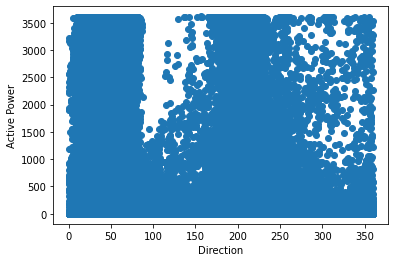

In [7]:
plt.scatter(df['Wind Speed'],df['Active Power'])
plt.xlabel('Wind Speed')
plt.ylabel('Active Power')
plt.show()

plt.scatter(df['Direction'],df['Active Power'])
plt.xlabel('Direction')
plt.ylabel('Active Power')
plt.show()

With the help of wind direction graph one can roughly conclude that the orientation of wind turbines is between 0-90 degrees and 180-270 degrees

# **Predicting Power using Wind Speed and Direction**


In [9]:
X_train = df[['Wind Speed','Direction']][1000:]
Y_train = df['Active Power'][1000:]

mlp = MLPRegressor(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=500)
mlp.fit(X_train,Y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(8, 8, 8), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=500,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [10]:
x_test = [[5.3,259.99]]
print(mlp.predict(x_test))

[296.2974931]


In [0]:
X_test = df[['Wind Speed','Direction']][:1000]
Y_test = df['Active Power'][:1000]

Y_predict = mlp.predict(X_test)

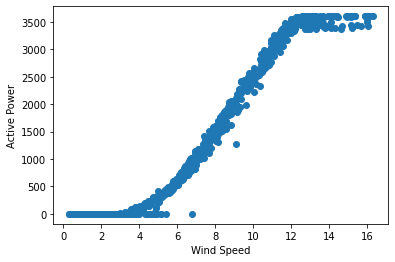

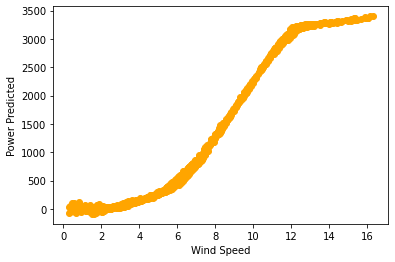

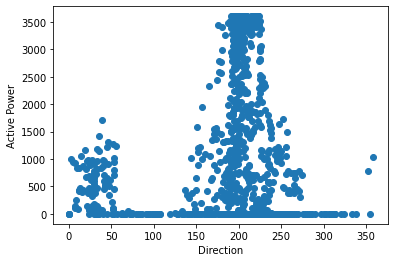

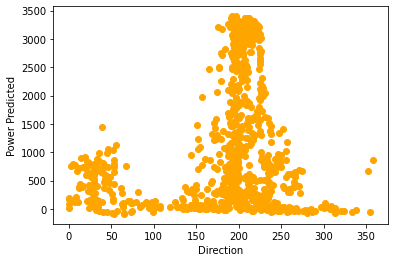

46788.11469401726

In [31]:
plt.scatter(df['Wind Speed'][:1000],df['Active Power'][:1000])
plt.xlabel('Wind Speed')  
plt.ylabel('Active Power') 
plt.show()

plt.scatter(df['Wind Speed'][:1000],Y_predict[:1000],color='orange')
plt.xlabel('Wind Speed') 
plt.ylabel('Power Predicted') 
plt.show()

plt.scatter(df['Direction'][:1000],df['Active Power'][:1000])
plt.xlabel('Direction')  
plt.ylabel('Active Power') 
plt.show()

plt.scatter(df['Direction'][:1000],Y_predict[:1000],color='orange')
plt.xlabel('Direction') 
plt.ylabel('Power Predicted') 
plt.show()

mean_squared_error(Y_test, Y_predict)

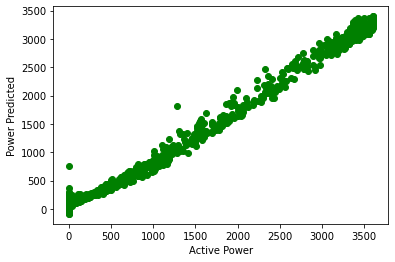

In [30]:

plt.scatter(df['Active Power'][:1000],Y_predict[:1000],color='green')
plt.xlabel('Active Power') 
plt.ylabel('Power Predicted') 
plt.show()

## **Time Series for Wind Speed and Direction**

In [33]:
df

,Date/Time,Active Power,Wind Speed,Theoritical Power,Direction,Loss
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,36.281117
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,66.148316
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,84.523429
3,2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,96.481664
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,111.052276
...,...,...,...,...,...,...
50525,2018-12-31 23:10:00,2963.980957,11.404030,3397.190793,80.502724,433.209835
50526,2018-12-31 23:20:00,1684.353027,7.332648,1173.055771,84.062599,-511.297256
50527,2018-12-31 23:30:00,2201.106934,8.435358,1788.284755,84.742500,-412.822178
50528,2018-12-31 23:40:00,2515.694092,9.421366,2418.382503,84.297913,-97.311588


In [46]:
df['Date/Time'] = pd.to_datetime(df['Date/Time'],format='%d %m %Y %H:%M')
df['Date'] = df['Date/Time'].dt.date
df['Time'] = df['Date/Time'].dt.time
df

,Date/Time,Active Power,Wind Speed,Theoritical Power,Direction,Loss,Date,Time
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,36.281117,2018-01-01,00:00:00
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,66.148316,2018-01-01,00:10:00
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,84.523429,2018-01-01,00:20:00
3,2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,96.481664,2018-01-01,00:30:00
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,111.052276,2018-01-01,00:40:00
...,...,...,...,...,...,...,...,...
50525,2018-12-31 23:10:00,2963.980957,11.404030,3397.190793,80.502724,433.209835,2018-12-31,23:10:00
50526,2018-12-31 23:20:00,1684.353027,7.332648,1173.055771,84.062599,-511.297256,2018-12-31,23:20:00
50527,2018-12-31 23:30:00,2201.106934,8.435358,1788.284755,84.742500,-412.822178,2018-12-31,23:30:00
50528,2018-12-31 23:40:00,2515.694092,9.421366,2418.382503,84.297913,-97.311588,2018-12-31,23:40:00


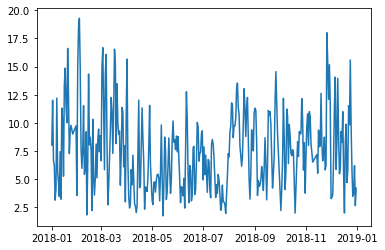

In [44]:
plot_data = df.groupby('Date')['Wind Speed'].mean()
plt.plot(plot_data.index,plot_data)
plt.show()

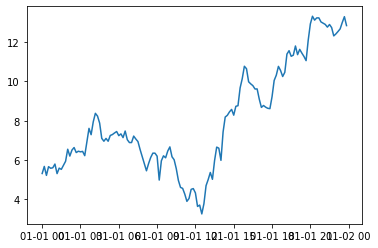

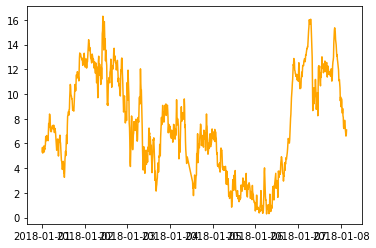

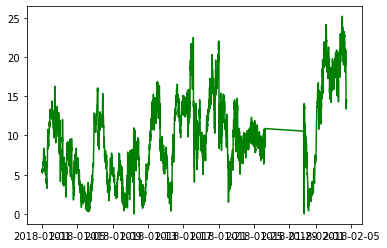

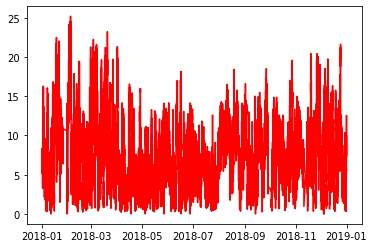

In [39]:
plt.plot(df['Date/Time'][:144],df['Wind Speed'][:144])
plt.show()
plt.plot(df['Date/Time'][:1008],df['Wind Speed'][:1008],color='orange')
plt.show()
plt.plot(df['Date/Time'][:4320],df['Wind Speed'][:4320],color='green')
plt.show()
plt.plot(df['Date/Time'],df['Wind Speed'],color='red')
plt.show()

In [0]:
from fbprophet import Prophet

In [53]:
m = {'ds':df['Date/Time'][:40000],'y':df['Wind Speed'][:40000]}
data_prophet = pd.DataFrame(m)
data_prophet

,ds,y
0,2018-01-01 00:00:00,5.311336
1,2018-01-01 00:10:00,5.672167
2,2018-01-01 00:20:00,5.216037
3,2018-01-01 00:30:00,5.659674
4,2018-01-01 00:40:00,5.577941
...,...,...
39995,2018-10-15 23:10:00,4.656672
39996,2018-10-15 23:20:00,4.304475
39997,2018-10-15 23:30:00,3.883235
39998,2018-10-15 23:40:00,3.693330


In [64]:
model = Prophet(changepoint_prior_scale=0.01)
model.fit(data_prophet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [89]:
future = model.make_future_dataframe(periods=1666, freq='H')
future.tail()

,ds
41661,2018-12-24 05:50:00
41662,2018-12-24 06:50:00
41663,2018-12-24 07:50:00
41664,2018-12-24 08:50:00
41665,2018-12-24 09:50:00


In [90]:
forecast=model.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
41661,2018-12-24 05:50:00,7.455483,0.542451,12.673496,4.099440,10.891533,-0.740622,-0.740622,-0.740622,-0.095077,-0.095077,-0.095077,-0.645545,-0.645545,-0.645545,0.0,0.0,0.0,6.714861
41662,2018-12-24 06:50:00,7.455209,0.130731,12.455812,4.096712,10.896046,-1.081369,-1.081369,-1.081369,-0.422278,-0.422278,-0.422278,-0.659091,-0.659091,-0.659091,0.0,0.0,0.0,6.373840
41663,2018-12-24 07:50:00,7.454935,-0.003226,12.531702,4.093984,10.900559,-1.325129,-1.325129,-1.325129,-0.657731,-0.657731,-0.657731,-0.667398,-0.667398,-0.667398,0.0,0.0,0.0,6.129806
41664,2018-12-24 08:50:00,7.454660,-0.031948,12.535347,4.091256,10.905072,-1.452290,-1.452290,-1.452290,-0.781700,-0.781700,-0.781700,-0.670590,-0.670590,-0.670590,0.0,0.0,0.0,6.002370
41665,2018-12-24 09:50:00,7.454386,-0.038679,12.140306,4.088528,10.909584,-1.506589,-1.506589,-1.506589,-0.837753,-0.837753,-0.837753,-0.668837,-0.668837,-0.668837,0.0,0.0,0.0,5.947797


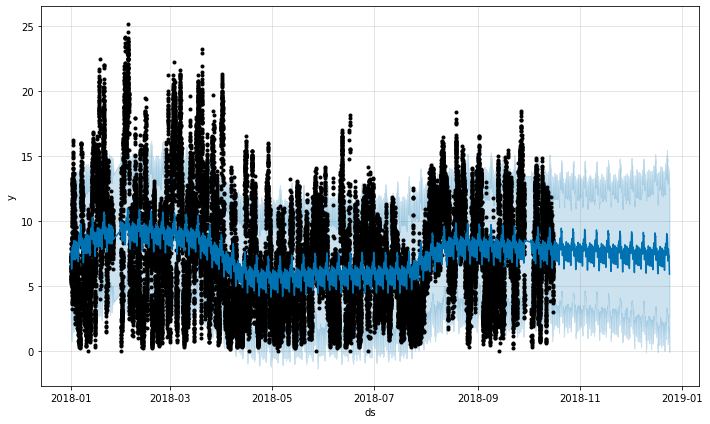

In [91]:
fig1=model.plot(forecast)

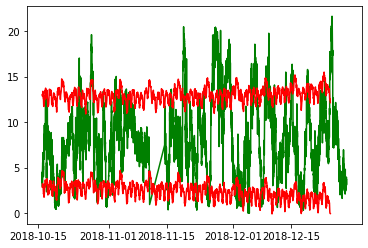

In [93]:
plt.plot(df['Date/Time'][40000:50000],df['Wind Speed'][40000:50000],color='green')
plt.plot(forecast['ds'][40000:],forecast['yhat_upper'][40000:],color='red')
plt.plot(forecast['ds'][40000:],forecast['yhat_lower'][40000:],color='red')
plt.show()